In [1]:
# automatically reload the package when it is modified
%load_ext autoreload
%autoreload 2

# Test Multiagent Simulation    

In [2]:
import jax
from jax import numpy as jnp
import numpy as np
import mediapy
from tqdm import tqdm
import dataclasses
import random
import torch
import tensorflow as tf

from waymax import config as _config
from waymax import dataloader
from waymax import datatypes
from waymax import dynamics
from waymax import env as _env
from waymax import agents
from waymax import visualization
from rl_env.waymax_env import MultiAgentEnvironment
from rl_env.env_utils import womd_loader
max_num_objects = 32
from rl_env.sim_agent_actor import SimAgentMTR

from mtr.config import cfg, cfg_from_yaml_file
cfg = cfg_from_yaml_file('tools/cfgs/waymo/rl_finetune.yaml', cfg)

# Import model
from mtr.models.context_encoder.mtr_encoder import MTREncoder
from mtr.models.motion_decoder.bc_decoder import BCDecoder


2023-12-08 21:27:45.740392: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-12-08 21:27:45.740421: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-12-08 21:27:45.740424: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/home/zixuzhang/mambaforge/envs/waymax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonote

# Define Environment

In [3]:
# create a dataset
WOMD_1_2_0_VAL_LOCAL = _config.DatasetConfig(
    path='/Data/Dataset/Waymo/V1_2_tf/validation_interactive/validation_interactive_tfexample.tfrecord@150',
    # path='/Data/Dataset/Waymo/V1_2_tf/validation/validation_tfexample.tfrecord@150',
    max_num_rg_points=30000,
    data_format=_config.DataFormat.TFRECORD,
    max_num_objects=max_num_objects,
    shuffle_seed = 0,
)

data_iter = womd_loader(data_config=WOMD_1_2_0_VAL_LOCAL)


# Config the multi-agent environment:
init_steps = 11

# Set the dynamics model the environment is using.
# Note each actor interacting with the environment needs to provide action
# compatible with this dynamics model.
dynamics_model = dynamics.DeltaLocal()

# Expect users to control all valid object in the scene.
env = MultiAgentEnvironment(
    dynamics_model=dynamics_model,
    config=dataclasses.replace(
        _config.EnvironmentConfig(),
        init_steps = init_steps,
        max_num_objects=max_num_objects,
        controlled_object=_config.ObjectType.MODELED,
        rewards = _config.LinearCombinationRewardConfig(
            rewards={
                'overlap': 1.0, # Positive is good.  
                'offroad': 1.0, # Negative is good.
                'kinematics': 1.0, # Negative is good.
            }
        )
    ),
)


# Define Control Policy

In [4]:
@jax.jit
def check_controlled(state: datatypes.SimulatorState):
    current_stamp = state.timestep
    is_valid = state.sim_trajectory.valid[..., current_stamp]
    
    is_modeled = jnp.logical_or(
        state.object_metadata.is_modeled,
        state.object_metadata.is_sdc
    )
    
    # is_modeled = is_valid
    # is_modeled.at[10:].set(False)
    is_vehicle = (state.object_metadata.object_types == 1)
    
    return jnp.logical_and(is_valid, jnp.logical_and(is_modeled, is_vehicle))

In [5]:
# Setup a few actors, see visualization below for how each actor behaves.

# An actor that doesn't move, controlling all objects with index > 4
obj_idx = jnp.arange(max_num_objects)
actor_gt = agents.create_expert_actor(
    dynamics_model=dynamics_model,
    is_controlled_func=lambda state: ~check_controlled(state),
)

actor_gt2 = agents.create_expert_actor(
    dynamics_model=dynamics_model,
    is_controlled_func=lambda state: state.object_metadata.is_valid,
)

encoder = MTREncoder(cfg.MODEL.CONTEXT_ENCODER)
decoder = BCDecoder(encoder.num_out_channels, cfg.MODEL.MOTION_DECODER)
# load model
state_dict = torch.load(
    'output/bc_atten_4_freeze/epoch=9-step=302840.ckpt',
    # 'output/bc_atten_4_unfreeze_state/epoch=19-step=1211340.ckpt',
    # 'output/bc_atten_2_freeze_bicycle/epoch=12-step=393692.ckpt',
    # 'output/bc_atten_2_unfreeze_bicycle/epoch=10-step=333124.ckpt',
    # 'output/bc_atten_2_freeze/epoch=49-step=152600.ckpt',
    # 'output/bc_atten_0_freeze/epoch=31-step=97664.ckpt',
    # 'output/bc_atten_0_unfreeze/epoch=31-step=97664.ckpt',
    )['state_dict']

encoder.load_model(state_dict)
decoder.load_model(state_dict)

actor_policy = SimAgentMTR(
    context_encoder= encoder,
    motion_decoder= decoder,
    is_controlled_func = check_controlled,
)

actor_policy.eval()
actor_policy.to('cuda')

actors = [actor_policy, actor_gt]

jit_select_action_list = [actor.select_action for actor in actors]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


""

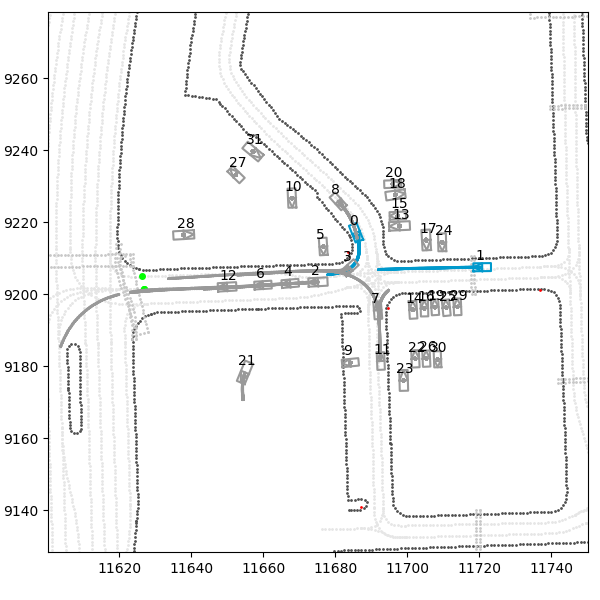

(Array([0, 1], dtype=int32),)


In [6]:
scenario_id, scenario = next(data_iter)
scenario : datatypes.SimulatorState
img = visualization.plot_simulator_state(scenario, use_log_traj=True, highlight_obj = _config.ObjectType.MODELED)
mediapy.show_image(img)
print(jnp.where(scenario.object_metadata.is_modeled))

In [7]:
# get a scenario from the dataset
# scenario : datatypes.SimulatorState = next(data_iter)
states = [env.reset(scenario)]
for _ in range(states[0].remaining_timesteps):
  current_state = states[-1]
  # vx = current_state.sim_trajectory.vel_x[0, current_state.timestep]
  # vy = current_state.sim_trajectory.vel_y[0, current_state.timestep]
  # print(np.sqrt(vx**2 + vy**2))
  policy_output = actor_policy.select_action({}, current_state, None, None)
  next_state = env.step_sim_agent(current_state, [policy_output])
  env.metrics(next_state, None)
  
  # metrics = env.metrics(next_state, None)
  # print(metrics.keys())
  # print(env.reward(current_state, action))
  states.append(next_state)
  
print("Sim Agent Ids:", jnp.where(policy_output.is_controlled))

[[1.3929287]
 [1.5809349]]
accel:  [ 1.8800616e+00  8.0022020e+00  3.1219605e-01  4.4400334e+00
  7.8539252e-01  0.0000000e+00  5.4168701e-03  9.8081589e-01
  4.2468190e-01  0.0000000e+00  0.0000000e+00 -1.9757056e+00
 -2.6684618e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  1.4004278e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
[[1.5809349]
 [1.342326 ]]
accel:  [-2.3860884   1.5455937   2.2008417  -2.5782132  -1.0903833   0.
  0.38983017  0.14110088  0.07510185  0.          0.          0.48213005
  1.6958594   0.          0.          0.          0.          0.
  0.          0.          0.         -2.7771068   0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
[[1.342326 ]
 [1.3306165]]
accel:  [-0.11709571  2.3926568   2.02397     4.081733 

In [16]:
imgs = []
for state in states:
  imgs.append(visualization.plot_simulator_state(state, use_log_traj=False, highlight_obj = _config.ObjectType.MODELED))
mediapy.show_video(imgs, fps=10)

: 